# Isolation Forests

### table of contents
* [introduction](#lit)
* [data processing](#data)
* [model building](#model)
 * [pipeline](#transform)
 * [accuracy](#accuracy)
* [conclsuion](#conclusion)

<a id='lit'></a>
### introduction

When detecting outliers we can have different scenarios depending on what data we have present. This will guide which approaches we would take.

* **Unsupservised (Outlier Detection)** We have an unlabeled training set that we assume contains normal and outlier points, and we want to use models that are robust enough that can igonore outliers as point away from the normal points.
* **Semi-Supervised (Novelty Detection)** We have a labeled training set containing only normal points that we fit a density for. We then predict whether the new points are anomalous or normal based on the training set.
* **Fully Supervised** We have a labeled training set of known normal and known outlier points. We fit the model only to normal points, and then choose the parameters and threshold that gives you the best accuracy based on the training data.

In this notebook, I used labelled data for an unsupervised approach to detech anomalies. I used the labels to just assess and compare it's performance. In the real world example, isolation forest does not need to see the labels while training. 

The term isolation means ‘separating an instance from the rest of the instances’. Since anomalies differ from all other points and the fact that they are fewer, they are more susceptible to isolation. Isolation forests work by randomly partitioning of instances are repeated recursively until all instances are isolated. 
This random partitioning produces noticeable shorter paths for anomalies since the fewer instances of anomalies result in a smaller number of partitions – shorter pathsin a tree structure, and instances with distinguishable attribute-values are more likely to be separated in early partitioning. Hence, when a forest of random trees collectively produce shorter path lengths for some particular points, then they are highly likely to be anomalies.

In principle, outliers are less frequent than regular observations and are different from them in terms of values (they lie further away from the regular observations in the feature space). That is why by using such random partitioning they should be identified closer to the root of the tree (shorter average path length, i.e., the number of edges an observation must pass in the tree going from the root to the terminal node), with fewer splits necessary.

The anomaly score is created on the basis of all trees in the forest and the depth the point reaches in these trees.
Isolation Forest algorithm utilizes the fact that anomalous observations are few and significantly different from ‘normal’ observations. The forest is built on the basis of decision trees, each of the trees having access to a sub-sample of the training data. In order to create a branch in the tree, first, a random feature is selected. Afterward, a random split value ( between min and max value) is chosen for that feature. If the given observation has a lower value of this feature then the one selected it follows the left branch, otherwise the right one. This process is continued until a single point is isolated or specified maximum depth is reached

#### things to note about Isolation Forest:
- it doesnt use distance's from points like other anomaly detection algoritms, for instance kmeans clustering.
- no profile of the "normal" cases unlike kmeans/LOF/dbscan
- can be scaled to handle large, high-dimensional data


In [1]:
### libraries
import numpy as np
import pandas as pd
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import savefig
from sklearn.ensemble import IsolationForest
import ipywidgets
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.compose import ColumnTransformer

<a id='data'></a>
### data processing

#### Dataset information
The original Cardiotocography (Cardio) dataset from UCI machine learning repository consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians. This is a classification dataset, where the classes are normal, suspect, and pathologic. For outlier detection, The normal class formed the inliers, while the pathologic (outlier) class is downsampled to 176 points. The suspect class is discarded.
http://odds.cs.stonybrook.edu/cardiotocogrpahy-dataset/

In [2]:
mat = scipy.io.loadmat('cardio.mat')
data=pd.DataFrame(np.hstack(((mat['X']), mat['y'])))
data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,-0.420487,...,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294,0.0
1,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,-0.420487,...,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294,0.0
2,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018,0.0
3,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018,0.0
4,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,-0.420487,...,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018,0.0


In [3]:
X = pd.DataFrame(mat['X'])
y = pd.Series([x[0] for x in mat['y']])


Things to note:
The average depth needs to be added to the depth once the current length hits the height limit
The path lengths are not normalized between trees and hence the actual values are used for plotting
The authors of the paper suggest using kurtosis to select features as a refinement over random selection

In [4]:
X.head(5)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,-0.420487,...,1.485973,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294
1,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,-0.420487,...,1.485973,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294
2,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,1.141780,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018
3,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,1.141780,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018
4,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,-0.420487,...,-0.208514,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018


In [5]:
# Train test split. train the model in a supervised setting. Therefore split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### model building

<a id='parameters'></a>
#### parameters
* n_estimators: The number of trees to use. The paper suggests an number of 100 trees, because the path lengths usually converges well before that.
* max_samples: The number of samples to draw while build a single tree. This parameter is called sub-sampeling in the paper and they suggest max_samples=256, since it generally provides enough details to perform anomaly detection across a wide range of data.
* contamination: the number of outliers we assume to be in the dataset. This number is set by knowledge of the domain. 

In [74]:
i_forest = IsolationForest(n_estimators=100,
                           max_samples=256,
                           random_state = np.random.RandomState(42),
                           behaviour="new",
                           contamination=0.1
)

##### transformers

In [75]:
# columns transformers
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer=Pipeline(steps=[
                             ('scaler', StandardScaler())])

preprocessor=ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])


In [76]:
if_pipeline=Pipeline(steps=[('preprocessor', preprocessor), 
                               ('classifier', i_forest)])

In [77]:
if_pipeline.fit(X_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), Int64Index([0, 1, 2, 3, 4, 5, 6, ... n_jobs=None,
        random_state=<mtrand.RandomState object at 0x1a20f88708>,
        verbose=0))])

In [78]:
y_pred = if_pipeline.predict(X_train)
# IF Returns -1 for outliers and 1 for inliers (sklearn documentation), so will change it to 1's and 0's to measure
y_pred = [1 if x == -1 else 0 for x in y_pred]

<a id='accuracy'></a>
#### accuracy

In [79]:
### functions
def accuracy_measures(y_test,y_pred):
    print("-----------------")
    print("Model Evaluation")
    print("-----------------")
    print("AUC: {:.1%}".format(roc_auc_score(y_test, y_pred)))
    print("Precision: {:.4f}".format(precision_score(y_test, y_pred)))
    print("Recall: {:.4f}".format(recall_score(y_test, y_pred)))
    print("F1: {:.4f}".format(f1_score(y_test, y_pred)))

    if_cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Anomaly'],['Pred Normal','Pred Anomaly'])
    ax=sns.set(font_scale=1.2)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,fmt="d")# font size
    plt.title('Confusion Matrix', size = 15) 
    


-----------------
Model Evaluation
-----------------
AUC: 71.5%
Precision: 0.4453
Recall: 0.4914
F1: 0.4672


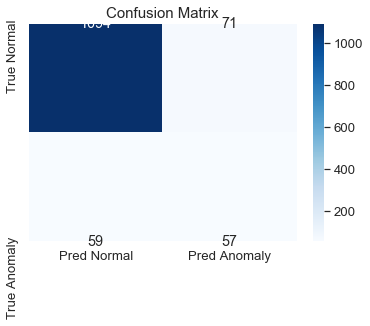

In [80]:
accuracy_measures(y_train, y_pred)

The model identifies 10% of the actual anomalies present in the data.

In [81]:
counter =0
for n in range(len(cc)):
    if (cc['Category'][n]== 1 and cc['scores'][n] >=0.5):
        counter= counter+1
print (counter)

NameError: name 'cc' is not defined

In [82]:
scores = i_forest.decision_function(X_train)

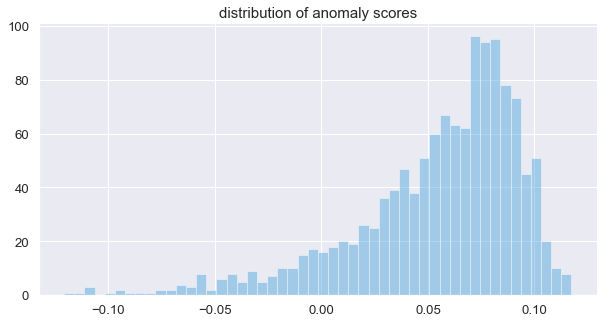

In [83]:

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
plt.figure(figsize=(10, 5))
ax=sns.distplot(scores, bins=50,kde=False,color="#3498db")# font size
sns.set_style('white')
plt.title('distribution of anomaly scores', size = 15) 
# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


##### anomaly scores
The .decision_function gives a score that is derived from the the average path lengths of the data points in the model.
Based on (Liu and Ting, 2008), the decision_function returns values in the range of [-0.5, 0.5] where -.5 is the most anomalous


The above graph shows the distribustion of the score assigned to anomalous and nonanomlous observations.

-----------------
Model Evaluation
-----------------
AUC: 81.4%
Precision: 0.6780
Recall: 0.6667
F1: 0.6723


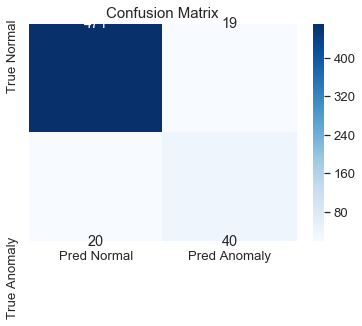

In [84]:
y_pred_test = if_pipeline.predict(X_test)
y_pred_test = [1 if x == -1 else 0 for x in y_pred_test]
accuracy_measures(y_test, y_pred_test)

In [85]:
new_pred = pd.DataFrame(y_pred) 
outliers=X_train.copy()
outliers['prediction']=new_pred

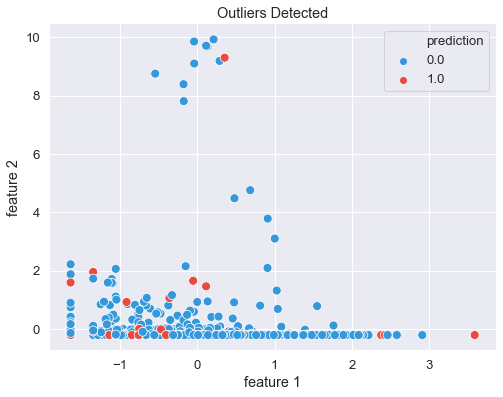

In [86]:
plt.figure(figsize = (8,6))
ax=sns.scatterplot(
    x=outliers[3],
    y=outliers[2],
    hue="prediction",
    data=outliers, s=80, 
    palette=["#3498db","#e74c3c"])

sns.set_style('white')

# Customize the axes and title
plt.title("Outliers Detected")
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


### Conclusion
Isolation Forest is an interesting outlier detection model which is worth further exploring. It works well in an unsupervised appraoch with a high dimensional feature set.

#### References

- https://www.slideshare.net/PyData/unsupervised-anomaly-detection-with-isolation-forest-elena-sharova?from_action=save
- https://towardsdatascience.com/outlier-detection-with-extended-isolation-forest-1e248a3fe97b
- https://medium.com/walmartlabs/swamping-and-masking-in-anomaly-detection-how-subsampling-in-isolation-forests-helps-mitigate-bb192a8f8dd5
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- http://sdsawtelle.github.io/blog/output/week9-anomaly-andrew-ng-machine-learning-with-python.html#Try-IsolationForests-for-High-Dimensions